In [1]:
from prophet import Prophet
import pandas as pd
import pandas_gbq
import os 
import yaml

from datetime import date

Importing plotly failed. Interactive plots will not work.


In [2]:
project_id = 'ferrous-weaver-306014'

In [3]:
query = """
select
    date(date(creation_datetime)) as ds,
    count(distinct ID) as y
from
    `clinical_reporting_pipeline.inbound_referrals` 
left join `analytics_manual.calendar` c 
     on date(date(creation_datetime)) = c.calendar_date
where
    client is not null
    and ID is not null
    and client in ('Conviva','Primus')
    and date(creation_datetime) >= '2025-04-01'
    and date_trunc(date(date(creation_datetime)),week) != date_trunc(date(current_date),week)
group by all
order by
    DS desc
"""

In [4]:
df = pandas_gbq.read_gbq(query, project_id=project_id)

/Users/fidelilustre/Library/Caches/pypoetry/virtualenvs/clinical-capacity-VvbFcoV3-py3.13/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [5]:
df.head()

,ds,y
0,2025-06-27,10
1,2025-06-26,15
2,2025-06-25,18
3,2025-06-24,11
4,2025-06-23,20


In [6]:
m = Prophet()
m.fit(df)

14:25:23 - cmdstanpy - INFO - Chain [1] start processing
14:25:24 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future = m.make_future_dataframe(periods=252)
future.tail()

,ds
311,2026-03-02
312,2026-03-03
313,2026-03-04
314,2026-03-05
315,2026-03-06


In [8]:
forecast = m.predict(future)

In [9]:
forecast["run_date"] = pd.to_datetime(date.today())

In [10]:
df_out = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','run_date']]
df_out.head()

,ds,yhat,yhat_lower,yhat_upper,run_date
0,2025-04-01,11.377693,6.512246,16.137477,2025-06-30
1,2025-04-02,14.993224,9.990512,20.283376,2025-06-30
2,2025-04-03,11.575013,6.432792,16.512040,2025-06-30
3,2025-04-04,10.993166,6.409521,15.824467,2025-06-30
4,2025-04-05,0.997013,-4.134183,6.032918,2025-06-30


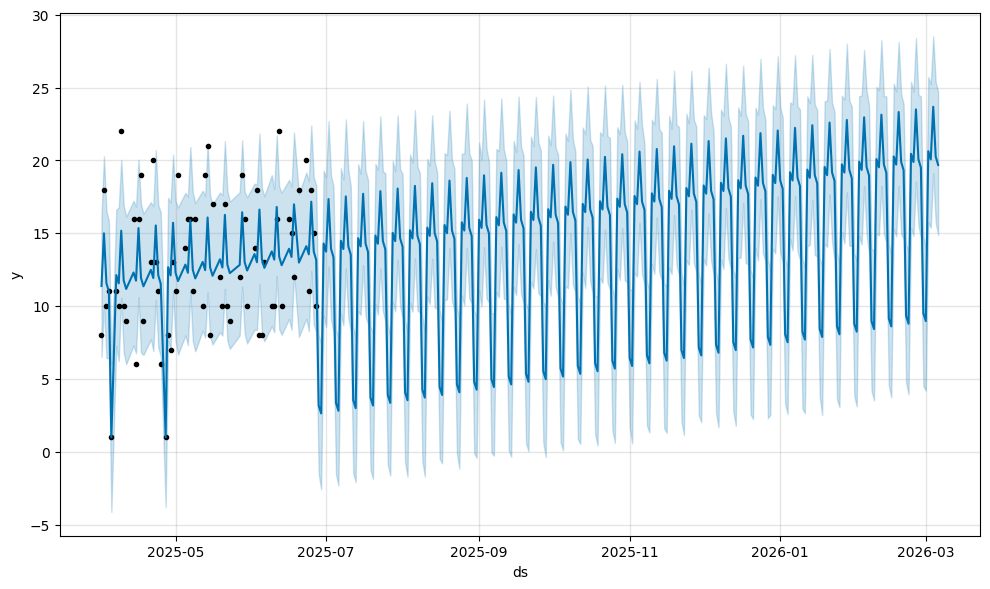

In [11]:
fig = m.plot(forecast)

In [12]:
pandas_gbq.to_gbq(
    df_out, 
    destination_table="capacity_plan.prophet_run",
    project_id=project_id,
    if_exists="replace"
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2624.72it/s]
